In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime, time

import talib as ta

import numpy as np
import pandas as pd
import pandas as DataFrame
import pandas.io.sql as pdsql
from pandas.plotting import scatter_matrix
from pandasql import sqldf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import dates
import matplotlib.font_manager as font_manager
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf

import mysql.connector
from mysql.connector.conversion import MySQLConverter

In [2]:
def comma_volume(x, pos=None):
    s = '{:0,d}K'.format(int(x/1000))
    return s

In [3]:
def comma_price(x, pos=None):
    s = '{:0,d}K'.format(int(x))
    return s

In [4]:
def comma_percent(x, pos=None):
    s = '{:+.2f}'.format(x)
    return s

In [5]:
major_date_formatter = dates.DateFormatter("%Y-%m-%d")
minor_date_formatter = dates.DateFormatter("%m")
price_formatter = ticker.FuncFormatter(comma_price)
volume_formatter = ticker.FuncFormatter(comma_volume)
percent_formatter = ticker.FuncFormatter(comma_percent)

In [6]:
init_notebook_mode(connected=True)
cf.go_offline()

In [7]:
from sklearn.preprocessing import MinMaxScaler

def MMS(data):
    data = np.array(data)
    scaler = MinMaxScaler()
    scaler.fit(np.reshape(data, (-1,1)))
    return scaler.transform(np.reshape(data[-1], (-1,1)))

In [8]:
def get_price(df):
    df['Fluctuation'] = np.log(df['close']/df['close'].shift(1))
    df['MA20'] = df['close'].rolling(window=20).mean()
    df['MA60'] = df['close'].rolling(window=60).mean()
    df['MA120'] = df['close'].rolling(window=120).mean()
    df['MA20P'] = df['close']/df['close'].rolling(window=20).mean()
    df['MA60P'] = df['close']/df['close'].rolling(window=60).mean()
    df['MA120P'] = df['close']/df['close'].rolling(window=120).mean()
    df['ATR'] = ta.ATR(np.array(df['high'].astype(float)), np.array(df['low'].astype(float)), np.array(df['close'].astype(float)), 30)
    df['slowk'], df['slowd'] = ta.STOCH(np.array(df['high'].astype(float)), np.array(df['low'].astype(float)), np.array(df['close'].astype(float)), fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['RSI'] = ta.RSI(np.array(df['close'].astype(float)))
    df['ADX'] = ta.ADX(np.array(df['high'].astype(float)), np.array(df['low'].astype(float)), np.array(df['close'].astype(float)))
    df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(np.array(df['close'].astype(float)), fastperiod=12, slowperiod=26, signalperiod=9)
    df['aroondown'], df['aroonup'] = ta.AROON(np.array(df['high'].astype(float)), np.array(df['low'].astype(float)))
    df['MOM'] = ta.MOM(np.array(df['close'].astype(float)), timeperiod=120) / df['close'].shift(120) * 100
    df['VAR'] = ta.VAR(np.array(df['close'].astype(float)))
    df['WILLR'] = ta.WILLR(np.array(df['high'].astype(float)), np.array(df['low'].astype(float)), np.array(df['close'].astype(float)), timeperiod=14)

    return df

In [9]:
def normalize_indicator(df):
    df['MMS_MA20P'] = df['MA20P'].rolling(window=20).apply(lambda x : MMS(x) * 100)
    df['MMS_MA60P'] = df['MA60P'].rolling(window=20).apply(lambda x : MMS(x) * 100)
    df['MMS_MA120P'] = df['MA120P'].rolling(window=20).apply(lambda x : MMS(x) * 100)
    df['MMS_ATR'] = df['ATR'].rolling(window=20).apply(lambda x : MMS(x) * 100)
    df['MMS_slowk'] = df['slowk'].rolling(window=20).apply(lambda x : MMS(x) * 100)
    df['MMS_slowd'] = df['slowd'].rolling(window=20).apply(lambda x : MMS(x) * 100)
    df['MMS_MOM'] = df['MOM'].rolling(window=20).apply(lambda x : MMS(x) * 100)
    df['MMS_RSI'] = df['RSI'].rolling(window=20).apply(lambda x : MMS(x) * 100)
    df['MMS_ADX'] = df['ADX'].rolling(window=20).apply(lambda x : MMS(x) * 100)
    df['MMS_macd'] = df['macd'].rolling(window=20).apply(lambda x : MMS(x) * 100)
    df['MMS_macdsignal'] = df['macdsignal'].rolling(window=20).apply(lambda x : MMS(x) * 100)
    df['MMS_macdhist'] = df['macdhist'].rolling(window=20).apply(lambda x : MMS(x) * 100)
    df['MMS_aroondown'] = df['aroondown'].rolling(window=20).apply(lambda x : MMS(x) * 100)
    df['MMS_aroonup'] = df['aroonup'].rolling(window=20).apply(lambda x : MMS(x) * 100)
    df['MMS_VAR'] = df['VAR'].rolling(window=20).apply(lambda x : MMS(x) * 100)
    df['MMS_WILLR'] = df['WILLR'].rolling(window=20).apply(lambda x : MMS(x) * 100)

    return df

In [10]:
def get_url(item_name, code_df): 
    code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False) 
    url = 'http://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=code[1:])

    print("요청 URL = {}".format(url)) 
    return url

code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0] 

# 종목코드가 6자리이기 때문에 6자리를 맞춰주기 위해 설정해줌 
code_df.종목코드 = code_df.종목코드.map('{:06d}'.format) 

# 우리가 필요한 것은 회사명과 종목코드이기 때문에 필요없는 column들은 제외해준다. 

code_df = code_df[['회사명', '종목코드']] 
# 한글로된 컬럼명을 영어로 바꿔준다. 
code_df = code_df.rename(columns={'회사명': 'name', '종목코드': 'code'}) 
code_df.head()

# 신라젠의 일자데이터 url 가져오기 
item_name='신라젠' 
url = get_url(item_name, code_df) 

# 일자 데이터를 담을 df라는 DataFrame 정의 
df = pd.DataFrame() 

# 1페이지에서 20페이지의 데이터만 가져오기 
for page in range(1, 100): 
    pg_url = '{url}&page={page}'.format(url=url, page=page) 
    df = df.append(pd.read_html(pg_url, header=0)[0], ignore_index=True) 
    
# df.dropna()를 이용해 결측값 있는 행 제거 
df = df.dropna() 

# 한글로 된 컬럼명을 영어로 바꿔줌
df = df.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', 
                         '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'})

# 데이터의 타입을 int형으로 바꿔줌 
df[['close', 'diff', 'open', 'high', 'low', 'volume']] = df[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(int) 

# 컬럼명 'date'의 타입을 date로 바꿔줌 
# df['date'] = pd.to_datetime(df['date'])
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")

# 일자(date)를 기준으로 오름차순 정렬 
df = df.sort_values(by=['date'], ascending=True)
df = df.set_index("date")

# 상위 5개 데이터 확인
df.head()

요청 URL = http://finance.naver.com/item/sise_day.nhn?code=215600


,close,diff,open,high,low,volume
date,,,,,,
2016-12-06,12850,650,13500,15050,12400,13725568
2016-12-06,12850,650,13500,15050,12400,13725568
2016-12-06,12850,650,13500,15050,12400,13725568
2016-12-06,12850,650,13500,15050,12400,13725568
2016-12-06,12850,650,13500,15050,12400,13725568


In [11]:
data = df
df = get_price(df)
normalized_data = normalize_indicator(df)
df = df[df.index.year >= 2017]
normalized_data = normalized_data[normalized_data.index.year >= 2017]
normalized_data.head()

,close,diff,open,high,low,volume,Fluctuation,MA20,MA60,MA120,...,MMS_MOM,MMS_RSI,MMS_ADX,MMS_macd,MMS_macdsignal,MMS_macdhist,MMS_aroondown,MMS_aroonup,MMS_VAR,MMS_WILLR
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,12950,300,13250,13250,12900,497396,-0.022902,12635.0,NaN,NaN,...,NaN,78.740546,NaN,NaN,NaN,NaN,7.142857,21.428571,8.010966,62.807782
2017-01-03,12750,200,13000,13150,12700,540369,-0.015565,12682.5,NaN,NaN,...,NaN,74.176793,NaN,NaN,NaN,NaN,0.000000,14.285714,6.305209,31.704180
2017-01-04,12850,100,12800,12900,12650,399112,0.007813,12735.0,NaN,NaN,...,NaN,76.317970,0.0,NaN,NaN,NaN,42.857143,7.142857,5.787390,35.670861
2017-01-05,13200,350,12950,13550,12800,1159516,0.026873,12805.0,NaN,NaN,...,NaN,83.342949,0.0,NaN,NaN,NaN,35.714286,0.000000,3.944099,52.814570
2017-01-06,13050,150,13250,13250,12950,385308,-0.011429,12897.5,NaN,NaN,...,NaN,58.118484,0.0,NaN,NaN,NaN,30.769231,7.142857,1.832298,28.087167


In [12]:
df.describe()

,close,diff,open,high,low,volume,Fluctuation,MA20,MA60,MA120,...,MMS_MOM,MMS_RSI,MMS_ADX,MMS_macd,MMS_macdsignal,MMS_macdhist,MMS_aroondown,MMS_aroonup,MMS_VAR,MMS_WILLR
count,834.000000,834.000000,834.000000,834.000000,834.000000,8.340000e+02,834.000000,834.00000,819.000000,759.000000,...,739.000000,834.000000,832.000000,826.000000,826.000000,826.000000,834.000000,834.000000,834.000000,834.000000
mean,48257.853717,1682.673861,48120.239808,49704.040767,46628.489209,3.452479e+06,-0.000109,48266.46283,48922.757224,51838.947409,...,48.711510,48.058996,45.451980,49.161498,49.219549,51.290529,46.291158,42.241204,27.525788,49.265584
std,33502.809580,2643.497115,33985.144116,35129.545127,32801.353541,5.901502e+06,0.054806,33017.20783,31966.564747,29539.687065,...,36.464441,36.900153,42.229410,43.655900,44.602627,40.119086,39.166129,37.460311,32.328273,34.723118
min,8140.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-0.356348,10134.50000,11069.000000,11512.833333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13262.500000,200.000000,13400.000000,14062.500000,12950.000000,7.911968e+05,-0.022900,13203.75000,14757.083333,18004.666667,...,12.618569,12.188370,0.000000,0.000000,0.000000,8.346823,0.000000,0.000000,3.573552,17.712481
50%,49400.000000,700.000000,49225.000000,50900.000000,48200.000000,1.792040e+06,0.000000,51498.75000,53815.000000,60177.916667,...,47.555369,44.630552,35.692407,44.658991,46.091717,50.997462,44.444444,35.714286,13.646682,47.726865
75%,74650.000000,2000.000000,74400.000000,76975.000000,72700.000000,3.708255e+06,0.020355,74622.50000,74151.666667,75424.583333,...,84.255004,84.796210,95.801317,100.000000,100.000000,95.720053,85.714286,78.571429,38.911727,83.456494
max,131000.000000,29400.000000,136100.000000,152300.000000,127700.000000,6.003751e+07,0.262364,111385.00000,104620.000000,99710.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [13]:
normalized_data.describe()

,close,diff,open,high,low,volume,Fluctuation,MA20,MA60,MA120,...,MMS_MOM,MMS_RSI,MMS_ADX,MMS_macd,MMS_macdsignal,MMS_macdhist,MMS_aroondown,MMS_aroonup,MMS_VAR,MMS_WILLR
count,834.000000,834.000000,834.000000,834.000000,834.000000,8.340000e+02,834.000000,834.00000,819.000000,759.000000,...,739.000000,834.000000,832.000000,826.000000,826.000000,826.000000,834.000000,834.000000,834.000000,834.000000
mean,48257.853717,1682.673861,48120.239808,49704.040767,46628.489209,3.452479e+06,-0.000109,48266.46283,48922.757224,51838.947409,...,48.711510,48.058996,45.451980,49.161498,49.219549,51.290529,46.291158,42.241204,27.525788,49.265584
std,33502.809580,2643.497115,33985.144116,35129.545127,32801.353541,5.901502e+06,0.054806,33017.20783,31966.564747,29539.687065,...,36.464441,36.900153,42.229410,43.655900,44.602627,40.119086,39.166129,37.460311,32.328273,34.723118
min,8140.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-0.356348,10134.50000,11069.000000,11512.833333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13262.500000,200.000000,13400.000000,14062.500000,12950.000000,7.911968e+05,-0.022900,13203.75000,14757.083333,18004.666667,...,12.618569,12.188370,0.000000,0.000000,0.000000,8.346823,0.000000,0.000000,3.573552,17.712481
50%,49400.000000,700.000000,49225.000000,50900.000000,48200.000000,1.792040e+06,0.000000,51498.75000,53815.000000,60177.916667,...,47.555369,44.630552,35.692407,44.658991,46.091717,50.997462,44.444444,35.714286,13.646682,47.726865
75%,74650.000000,2000.000000,74400.000000,76975.000000,72700.000000,3.708255e+06,0.020355,74622.50000,74151.666667,75424.583333,...,84.255004,84.796210,95.801317,100.000000,100.000000,95.720053,85.714286,78.571429,38.911727,83.456494
max,131000.000000,29400.000000,136100.000000,152300.000000,127700.000000,6.003751e+07,0.262364,111385.00000,104620.000000,99710.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [14]:
corr = normalized_data[['MMS_MA20P','MMS_MA60P','MMS_MA120P','MMS_ATR','MMS_slowk','MMS_slowd','MMS_MOM','MMS_RSI','MMS_ADX','MMS_macd','MMS_macdsignal','MMS_macdhist','MMS_aroondown','MMS_aroonup','MMS_VAR','MMS_WILLR']].corr()

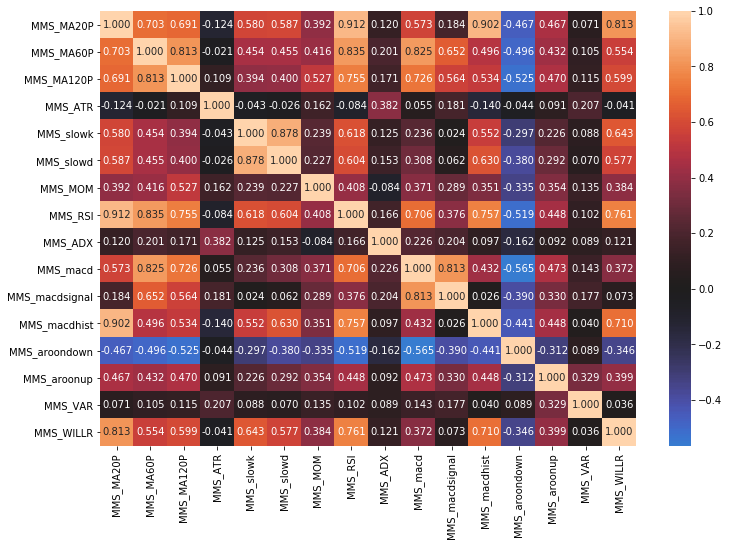

In [15]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,8))
sns.heatmap(ax=ax, data=corr, center=0, annot=True, fmt="0.3f")
plt.show()

In [57]:
from sklearn.preprocessing import MinMaxScaler

def MMS(data):
    data = np.array(data)
    scaler = MinMaxScaler()
    scaler.fit(np.reshape(data, (-1,1)))
    return scaler.transform(np.reshape(data[-1], (-1,1)))

df['MMS'] = df['RSI'].rolling(window=20).apply(lambda x : MMS(x) * 100)

df[['MMS','RSI','close','MA60']].iplot(secondary_y=['close','MA60'], hline=[50],
                                      hspan=[{'y0':'0','y1':'25','color':'rgba(30,30,30,0.3)','fill':True,'opacity':.4},
                                             {'y0':'26','y1':'50','color':'rgba(30,30,30,0.1)','fill':True,'opacity':.4},
                                             {'y0':'51','y1':'75','color':'rgba(30,30,30,0.1)','fill':True,'opacity':.4},
                                            {'y0':'76','y1':'100','color':'rgba(30,30,30,0.3)','fill':True,'opacity':.4}])

In [17]:
from sklearn.preprocessing import MaxAbsScaler

def MAS(data):
    data = np.array(data)
    scaler = MaxAbsScaler()
    scaler.fit(np.reshape(data, (-1,1)))
    return scaler.transform(np.reshape(data[-1], (-1,1)))

df['MAS'] = df['RSI'].rolling(window=360).apply(lambda x : MAS(x) * 100)

df[['MAS','RSI','close','MA60']].iplot(secondary_y=['close','MA60'], hline=[50],
                                      hspan=[{'y0':'0','y1':'20','color':'rgba(30,30,30,0.3)','fill':True,'opacity':.4},
                                            {'y0':'80','y1':'100','color':'rgba(30,30,30,0.3)','fill':True,'opacity':.4}])

In [18]:
from sklearn.preprocessing import RobustScaler

def RS(data):
    data = np.array(data)
    scaler = RobustScaler()
    scaler.fit(np.reshape(data, (-1,1)))
    return scaler.transform(np.reshape(data[-1], (-1,1)))

df['RS'] = df['RSI'].rolling(window=60).apply(lambda x : RS(x)*100)
df['RS'] = df['RS'].rolling(window=60).apply(lambda x : MMS(x) * 100)

df[['RS','RSI','close','MA60']].iplot(secondary_y=['close','MA60'], hline=[50],
                                      hspan=[{'y0':'0','y1':'20','color':'rgba(30,30,30,0.3)','fill':True,'opacity':.4},
                                            {'y0':'80','y1':'100','color':'rgba(30,30,30,0.3)','fill':True,'opacity':.4}])

In [19]:
from sklearn.preprocessing import StandardScaler

def SS(data):
    data = np.array(data)
    scaler = StandardScaler()
    scaler.fit(np.reshape(data, (-1,1)))
    return scaler.transform(np.reshape(data[-1], (-1,1)))

df['SS'] = df['RSI'].rolling(window=360).apply(lambda x : SS(x) * 100)
df['SS'] = df['SS'].rolling(window=60).apply(lambda x : MMS(x) * 100)

df[['SS','RSI','close','MA60']].iplot(secondary_y=['close','MA60'], hline=[50],
                                      hspan=[{'y0':'0','y1':'20','color':'rgba(30,30,30,0.3)','fill':True,'opacity':.4},
                                            {'y0':'80','y1':'100','color':'rgba(30,30,30,0.3)','fill':True,'opacity':.4}])

In [20]:
from sklearn.preprocessing import Binarizer

def BI(data):
    data = np.array(data)
    scaler = Binarizer(threshold=30.0)
    scaler.fit(np.reshape(data, (-1,1)))
    return scaler.transform(np.reshape(data[-1], (-1,1)))

df['BI'] = df['RSI'].rolling(window=360).apply(lambda x : BI(x) * 100)

df[['BI','RSI','close','MA60']].iplot(secondary_y=['close','MA60'], hline=[50],
                                      hspan=[{'y0':'0','y1':'20','color':'rgba(30,30,30,0.3)','fill':True,'opacity':.4},
                                            {'y0':'80','y1':'100','color':'rgba(30,30,30,0.3)','fill':True,'opacity':.4}])

In [21]:
df['MMS'] = df['ATR'].rolling(window=20).apply(lambda x : MMS(x) * 100)
df['slowk'] = df['slowk'] * 100

df[['MMS','RSI','close','slowk']].iplot(secondary_y=['close','slowk'], hline=[50],
                                      hspan=[{'y0':'0','y1':'25','color':'rgba(30,30,30,0.3)','fill':True,'opacity':.4},
                                            {'y0':'75','y1':'100','color':'rgba(30,30,30,0.3)','fill':True,'opacity':.4}])

In [22]:
indic = 'MMS_RSI'
bins = list(range(0,101,25))
bin_labels = ['{}_{}'.format(indic,i) for i,_ in enumerate(bins)]
bin_labels

['MMS_RSI_0', 'MMS_RSI_1', 'MMS_RSI_2', 'MMS_RSI_3', 'MMS_RSI_4']

In [23]:
df["level"] = pd.cut(normalized_data['MMS_RSI'], bins, right=False, labels=bin_labels[:-1])
df["level"]

date
2017-01-02    MMS_RSI_3
2017-01-03    MMS_RSI_2
2017-01-04    MMS_RSI_3
2017-01-05    MMS_RSI_3
2017-01-06    MMS_RSI_2
                ...    
2020-05-25    MMS_RSI_0
2020-05-26    MMS_RSI_0
2020-05-27    MMS_RSI_0
2020-05-28    MMS_RSI_0
2020-05-29    MMS_RSI_0
Name: level, Length: 834, dtype: category
Categories (4, object): [MMS_RSI_0 < MMS_RSI_1 < MMS_RSI_2 < MMS_RSI_3]

In [24]:
def leveling_indicator(normalized_data, data):
    level_data = pd.DataFrame()
    level_data = level_data.append(data)
    category = list(range(0,101,25))
    level_data['level_MA20P'] = level(normalized_data['MMS_MA20P'], 'MA20P', category)
    level_data['level_MA60P'] = level(normalized_data['MMS_MA60P'], 'MA60P', category)
    level_data['level_MA120P'] = level(normalized_data['MMS_MA120P'], 'MA120P', category)
    level_data['level_ATR'] = level(normalized_data['MMS_ATR'], 'ATR', category)
    level_data['level_slowk'] = level(normalized_data['MMS_slowk'], 'slowk', category)
    level_data['level_slowd'] = level(normalized_data['MMS_slowd'], 'slowd', category)
    level_data['level_MOM'] = level(normalized_data['MMS_MOM'], 'MOM', category)
    level_data['level_RSI'] = level(normalized_data['MMS_RSI'], 'RSI', category)
    level_data['level_ADX'] = level(normalized_data['MMS_ADX'], 'ADX', category)
    level_data['level_macd'] = level(normalized_data['MMS_macd'], 'macd', category)
    level_data['level_macdsignal'] = level(normalized_data['MMS_macdsignal'], 'macdsignal', category)
    level_data['level_macdhist'] = level(normalized_data['MMS_macdhist'], 'macdhist', category)
    level_data['level_aroondown'] = level(normalized_data['MMS_aroondown'], 'aroondown', category)
    level_data['level_aroonup'] = level(normalized_data['MMS_aroonup'], 'aroonup', category)
    level_data['level_VAR'] = level(normalized_data['MMS_VAR'], 'VAR', category)
    level_data['level_WILLR'] = level(normalized_data['MMS_WILLR'], 'WILLR', category)

    return level_data


In [26]:
def level(data, indicator, category):
    data = np.array(data)
    bin_labels = ['{}_{}'.format(indicator,i) for i,_ in enumerate(category)]
    data = pd.cut(data, category, right=False, labels=bin_labels[:-1])

    return np.array(data)


In [28]:
leveling_data = leveling_indicator(normalized_data, df)
leveling_data = leveling_data[leveling_data.index.year >= 2017]

In [42]:
from mlxtend.frequent_patterns import apriori, association_rules 
level_data.columns 

Index(['level_MA20P', 'level_MA60P', 'level_MA120P', 'level_ATR',
       'level_slowk', 'level_slowd', 'level_MOM', 'level_RSI', 'level_ADX',
       'level_macd', 'level_macdsignal', 'level_macdhist', 'level_aroondown',
       'level_aroonup', 'level_VAR', 'level_WILLR'],
      dtype='object')

In [44]:
level_data.level_MA20P.unique() 

array(['MA20P_1', 'MA20P_0', 'MA20P_2', 'MA20P_3', nan], dtype=object)

In [41]:
from apyori import apriori

level_data = leveling_data[['level_MA20P','level_MA60P','level_MA120P','level_ATR','level_slowk','level_slowd','level_MOM','level_RSI','level_ADX','level_macd','level_macdsignal','level_macdhist','level_aroondown','level_aroonup','level_VAR','level_WILLR']]

observation = []
for i in range(len(level_data)):
    observation.append([str(level_data.values[i,j]) for j in range(16)])

associations = apriori(observation, min_length = 2, min_support = 0.3, min_confidence = 0.2, min_lift = 2)
associations = list(associations)
print(associations[0])

rules = 

RelationRecord(items=frozenset({'MA20P_0', 'RSI_0'}), support=0.31894484412470026, ordered_statistics=[OrderedStatistic(items_base=frozenset({'MA20P_0'}), items_add=frozenset({'RSI_0'}), confidence=0.8636363636363638, lift=2.293862188766648), OrderedStatistic(items_base=frozenset({'RSI_0'}), items_add=frozenset({'MA20P_0'}), confidence=0.8471337579617835, lift=2.2938621887666475)])


In [46]:
for item in associations:

    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("Rule: " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(item[1]))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")

Rule: MA20P_0 -> RSI_0
Support: 0.31894484412470026
Confidence: 0.8636363636363638
Lift: 2.293862188766648
Rule: MA20P_0 -> macdhist_0
Support: 0.31414868105515587
Confidence: 0.8506493506493507
Lift: 2.3033816832518133
Rule: MA60P_0 -> macd_0
Support: 0.30815347721822545
Confidence: 0.8682432432432433
Lift: 2.045522217132387


In [58]:
normalized_data[['close','MMS_MA20P','MMS_MA60P','MMS_MA120P','MMS_ATR','MMS_slowk','MMS_slowd','MMS_MOM','MMS_RSI','MMS_ADX','MMS_macd','MMS_macdsignal','MMS_macdhist','MMS_aroondown','MMS_aroonup','MMS_VAR','MMS_WILLR']].iplot(secondary_y=['close'], hline=[50],
                                      hspan=[{'y0':'0','y1':'25','color':'rgba(30,30,30,0.3)','fill':True,'opacity':.4},
                                             {'y0':'26','y1':'50','color':'rgba(30,30,30,0.1)','fill':True,'opacity':.4},
                                             {'y0':'51','y1':'75','color':'rgba(30,30,30,0.1)','fill':True,'opacity':.4},
                                            {'y0':'76','y1':'100','color':'rgba(30,30,30,0.3)','fill':True,'opacity':.4}])